# Maximize the correlation between the ratio of bad pLDDT and our metrics
Because iupred_auc_normalized, repeat_6mers_normalized and non_repeat_6mers_normalized on their own just got a small correlation, we investigate here what happens if we just compute weights that maximize correlation. Can we use these to predict?

In [1]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [5]:
# Filter to sequences that have IUPred AUC and remove outliers
df_with_outliers = df_with_outliers[df_with_outliers['iupred_auc'].notnull()]
df_with_outliers['iupred_auc_normalized'] = df_with_outliers['iupred_auc'] / df_with_outliers['seq_len']
df_with_outliers.nlargest(n=10, columns='iupred_auc_normalized')
df = df_with_outliers[df_with_outliers['iupred_auc_normalized'] < 1.6]

In [7]:
# Use 6mer counts of 2k most common and normalize
df['repeat_6mers'] = df['repeat_6mers_2000']
df['non_repeat_6mers'] = df['non_repeat_6mers_2000']
df = df[(df['repeat_6mers'].notnull() & df['non_repeat_6mers'].notnull())].copy()
df['repeat_6mers_normalized'] = df['repeat_6mers'] / df['seq_len']
df['non_repeat_6mers_normalized'] = df['non_repeat_6mers'] / df['seq_len']

In [8]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,iupred_auc_normalized,repeat_6mers_normalized,non_repeat_6mers_normalized
count,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000,513489.000000,514617.000000,514617.000000,514617.000000,514617.000000,514617.000000
mean,419.081513,0.570992,30.832085,33.822719,75.292741,79.043795,0.356778,126.146083,0.755632,0.976800,0.583856,0.019857,-0.311985,0.755632,0.976800,0.287506,0.001580,0.002406
std,343.523527,1.108974,1.480735,11.471807,15.024630,18.830889,0.292574,147.638547,5.020153,3.640881,4.739819,0.394821,0.317157,5.020153,3.640881,0.174953,0.009674,0.008889
min,18.000000,0.000000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.987435,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.000000,0.000000,30.900000,25.650000,64.816400,64.350000,0.112000,37.994800,0.000000,0.000000,0.000000,0.000000,-0.564031,0.000000,0.000000,0.162898,0.000000,0.000000
50%,330.000000,0.000000,31.300000,31.230000,77.941700,87.310000,0.274100,80.004000,0.000000,0.000000,0.000000,0.000000,-0.345590,0.000000,0.000000,0.255811,0.000000,0.000000
75%,534.000000,1.000000,31.400000,38.710000,87.666800,94.025000,0.556400,156.731800,0.000000,1.000000,0.000000,0.000000,-0.103959,0.000000,1.000000,0.387581,0.000000,0.001862
max,2699.000000,46.000000,31.700000,97.030000,98.724100,98.860000,1.000000,2123.831300,386.000000,673.000000,382.000000,83.000000,0.918797,386.000000,673.000000,1.342777,0.807487,0.771930


In [10]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['iupred_auc_normalized'])
print(f'Spearman rank correlation (IUPred AUC): {"{0:.4f}".format(rho)}')
rho1, p1 = spearmanr(df['ratio_bad_plddt'], df['repeat_6mers_normalized'])
print(f'Spearman rank correlation (Repeat): {"{0:.4f}".format(rho1)}')
rho2, p2 = spearmanr(df['ratio_bad_plddt'], df['non_repeat_6mers_normalized'])
print(f'Spearman rank correlation (Non-repeat): {"{0:.4f}".format(rho2)}')

Spearman rank correlation (IUPred AUC): 0.4541
Spearman rank correlation (Repeat): 0.2417
Spearman rank correlation (Non-repeat): 0.1342


In [25]:
weights = np.asarray([0.33, 0.33, 0.33])
all_weights = []

In [28]:
import scipy.optimize as opt


def fun(w):
    v = w[0] * df['iupred_auc_normalized'] + w[1] * df['repeat_6mers_normalized'] + w[2] * df['non_repeat_6mers_normalized']
    r, _ = spearmanr(df['ratio_bad_plddt'], v)
    # abs to turn into minimization problem
    return -np.abs(r)

for _ in range(5):
    all_weights.append(weights)
    res = opt.minimize(fun, weights)
    weights = res.x
    print(f'Spearman rank correlation (Optimized): {"{0:.4f}".format(-res.fun)}')

Spearman rank correlation (Optimized): 0.4641
Spearman rank correlation (Optimized): 0.4642
Spearman rank correlation (Optimized): 0.4642
Spearman rank correlation (Optimized): 0.4642
Spearman rank correlation (Optimized): 0.4642


In [29]:
x = weights[0] * df['iupred_auc_normalized'] + weights[1] * df['repeat_6mers_normalized'] + weights[2] * df['non_repeat_6mers_normalized']
rho_x, p_x = spearmanr(df['ratio_bad_plddt'], x)
print(f'Spearman rank correlation (Optimized): {"{0:.4f}".format(rho_x)}')

Spearman rank correlation (Optimized): 0.4642


In [33]:
all_weights = np.asarray(all_weights)

xs = [spearmanr(df['ratio_bad_plddt'], w[0] * df['iupred_auc_normalized'] + w[1] * df['repeat_6mers_normalized'] + w[2] * df['non_repeat_6mers_normalized'])[0] for w in all_weights]

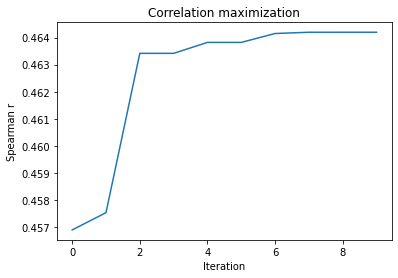

In [38]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(range(len(all_weights)), xs)
ax.set_title('Correlation maximization')
ax.set_ylabel('Spearman r')
ax.set_xlabel('Iteration')

plt.show()